<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [8]:
!subst N: E:\Network_Data_Sync
!subst S: E:\Network_Data_Sync
!subst O: "E:\OneDrive - Washington University in St. Louis"

Invalid parameter - N:
Drive already SUBSTed
Drive already SUBSTed


In [1]:
# reload the libs as we edit them
%load_ext autoreload
%autoreload 2

In [4]:
# load corr feat tsr
import numpy as np
from scipy.io import loadmat
from os.path import join
from sklearn.decomposition import NMF
import matplotlib.pylab as plt
from numpy.linalg import norm as npnorm
mat_path = r"E:\OneDrive - Washington University in St. Louis\Mat_Statistics"
def show_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def rectify_tsr(Ttsr, mode="abs", thr=(-5, 5)):
    if mode is "pos_rect":
        Ttsr_pp = np.clip(Ttsr, 0, None)
    elif mode is "abs":
        Ttsr_pp = np.abs(Ttsr)
    elif mode is "thresh":
        Ttsr_pp = Ttsr.copy()
        Ttsr_pp[(Ttsr<thr[1])*(Ttsr>thr[0])] = 0
        Ttsr_pp = np.abs(Ttsr_pp)
    else:
        raise ValueError
    return Ttsr_pp

def tsr_factorize(Ttsr_pp, cctsr, bdr=2, Nfactor=3):
    C, H, W = Ttsr_pp.shape
    if bdr == 0:
        Tmat = Ttsr_pp.reshape(C, H*W)
        ccmat = cctsr.reshape(C, H*W)
    else:
        Tmat = Ttsr_pp[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
        ccmat = cctsr[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
    #%
    nmfsolver = NMF(n_components=Nfactor, init="nndsvda", solver="cd")#mu
    Hmat = nmfsolver.fit_transform(Tmat.T)
    Hmaps = Hmat.reshape([H-2*bdr, W-2*bdr, Nfactor])
    exp_var = 1-npnorm(Tmat.T-Hmat@nmfsolver.components_)/npnorm(Tmat)
    print("NMF explained variance %.3f"%exp_var)
    ccfactor = (ccmat @ np.linalg.pinv(Hmat).T )
    # ccfactor = (ccmat @ Hmat )
    reg_cc = np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]
    print("Predictability of the corr coef tensor %.3f"%reg_cc)

    plt.imshow(Hmaps[:,:,:3] / Hmaps[:,:,:3].max())
    plt.title("channel merged")
    plt.show()
    [figh, axs] = plt.subplots(1,Nfactor,figsize=[Nfactor*2.7, 2.5])
    for ci in range(Hmaps.shape[2]):
        plt.sca(axs[ci])
        plt.imshow(Hmaps[:,:,ci] / Hmaps.max())
        plt.axis("off")
        plt.colorbar()
    plt.suptitle("Separate Factors")
    plt.show()
    featvecs = nmfsolver.components_
    fact_norms = []
    for i in range(Hmaps.shape[2]):
        rank1_mat = Hmat[:, i:i+1]@featvecs[i:i+1, :]
        matnorm = npnorm(rank1_mat, ord="fro")
        fact_norms.append(matnorm)
        print("Factor%d norm %.2f"%(i, matnorm))
    return Hmat, Hmaps, nmfsolver.components_, ccfactor


def torch_pearsonr(x, y):
    """
    Mimics `scipy.stats.pearsonr`
    Arguments
    ---------
    x : 1D torch.Tensor
    y : 1D torch.Tensor
    Returns
    -------
    r_val : float
        pearsonr correlation coefficient between x and y
    """
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    xm = x.sub(mean_x)
    ym = y.sub(mean_y)
    r_num = xm.dot(ym)
    r_den = torch.norm(xm, 2) * torch.norm(ym, 2)
    r_val = r_num / r_den
    return r_val

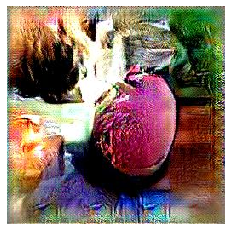

In [14]:
# Animal = "Beto"; Expi = 11
Animal = "Alfa"; Expi = 3

corrDict = np.load(join("S:\corrFeatTsr","%s_Exp%d_Evol_corrTsr.npz"%(Animal,Expi)), allow_pickle=True)#_nobdr
cctsr_dict = corrDict.get("cctsr").item()
Ttsr_dict = corrDict.get("Ttsr").item()

ReprStats = loadmat(join(mat_path, Animal + "_ImageRepr.mat"), struct_as_record=False, squeeze_me=True, chars_as_strings=True)['ReprStats']
show_img(ReprStats[Expi-1].Manif.BestImg)

NMF explained variance 0.479
Predictability of the corr coef tensor 0.465
Factor0 norm 1427.34
Factor1 norm 2155.09
Factor2 norm 2048.01


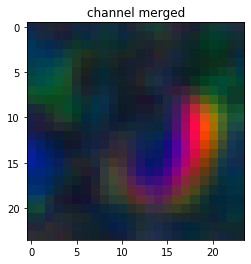

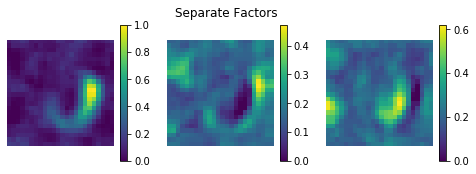

In [24]:
layer = "conv4_3"
bdr = 2
Ttsr = Ttsr_dict[layer]
cctsr = cctsr_dict[layer]
Ttsr_pp = rectify_tsr(Ttsr, mode="abs")
Hmat, Hmaps, Tcomponents_, ccfactor = tsr_factorize(Ttsr_pp, cctsr, bdr=bdr, Nfactor=3)

Factor0 norm 1331.94
Factor1 norm 2132.58
Factor2 norm 1866.22


Now let's load up the network and Generator, visualize the contents for this neuron group / feature vector

In [22]:
from CorrFeatTsr_visualize import CorrFeatScore, corr_GAN_visualize, preprocess
from GAN_utils import upconvGAN
import torch
from torchvision import models

In [18]:
VGG = models.vgg16(pretrained=True)
VGG.requires_grad_(False)
VGG.features.cuda().eval()
G = upconvGAN("fc6").cuda()
G.requires_grad_(False)

upconvGAN(
  (G): Sequential(
    (defc7): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc7): LeakyReLU(negative_slope=0.3, inplace=True)
    (defc6): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc6): LeakyReLU(negative_slope=0.3, inplace=True)
    (defc5): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc5): LeakyReLU(negative_slope=0.3, inplace=True)
    (reshape): View()
    (deconv5): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu_deconv5): LeakyReLU(negative_slope=0.3, inplace=True)
    (conv5_1): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv5_1): LeakyReLU(negative_slope=0.3, inplace=True)
    (deconv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu_deconv4): LeakyReLU(negative_slope=0.3, inplace=True)
    (conv4_1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

Visualize the feature vector without spatial structure, (full feature map)

D:\Github\Visual_Neuron_Modelling\CorrFeatTsr_visualize.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight_tsr[layer] = torch.tensor(weight).float().cuda()
step 99, score 50.49 49.14 49.46 54.47: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


Final scores 12.65 9.43 8.42 7.37
Final scores 52.61 50.69 47.89 46.49
Final scores 54.47 50.49 49.46 49.14


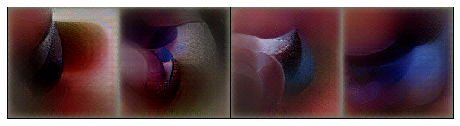

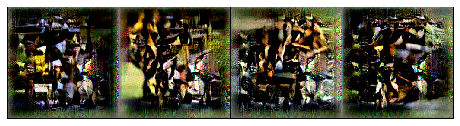

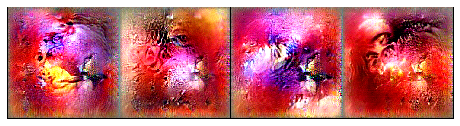

In [31]:
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
for ci in [0, 1, 2]:
    fact_W = torch.from_numpy(ccfactor[:, ci]).reshape([-1,1,1])
    scorer.register_weights({layer: fact_W.unsqueeze(0)})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.025, MAXSTEP=100, imshow=True, verbose=False, adam=True)
scorer.clear_hook()

In [20]:
scorer.clear_hook()
torch.cuda.empty_cache()

Visualize the feature vector times the spatial mask from regressing the correlation tensor, (structured feature map)

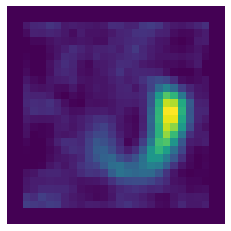

step 99, score 0.07 0.08 0.08 0.08: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


Final scores 0.03 0.02 0.02 0.02
Final scores 0.05 0.04 0.04 0.04
Final scores 0.08 0.08 0.08 0.07


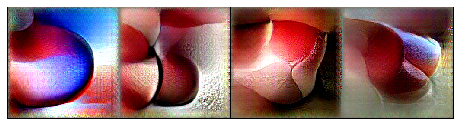

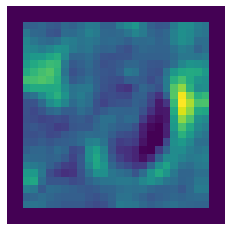

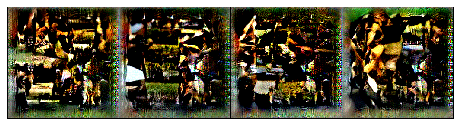

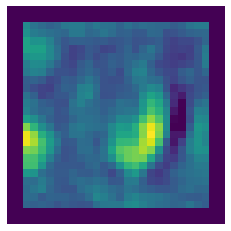

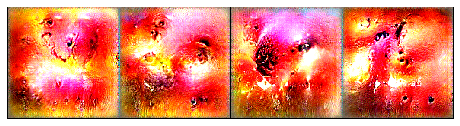

In [29]:
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
for ci in [0, 1, 2]:
    padded_mask = np.pad(Hmaps[:,:,ci:ci+1], ((bdr,bdr),(bdr,bdr),(0,0)),mode="constant")
    fact_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, ci:ci+1], padded_mask))
    show_img(padded_mask[:,:,0])
    scorer.register_weights({layer: fact_Wtsr})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.1, MAXSTEP=100, imshow=True, verbose=False)
scorer.clear_hook()

Visualize the feature vector at the center of the feature map, (structured feature map)

step 99, score 0.00 0.00 0.00 0.00: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


Feature Correlator Destructed, Hooks deleted.
Final scores 0.00 0.00 0.00 0.00
Final scores 0.00 0.00 0.00 0.00
Final scores 0.00 0.00 0.00 0.00


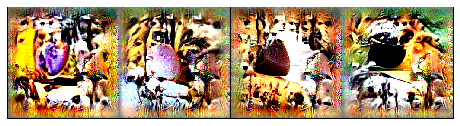

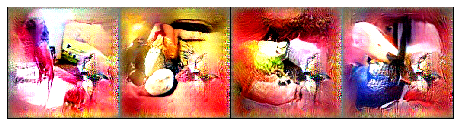

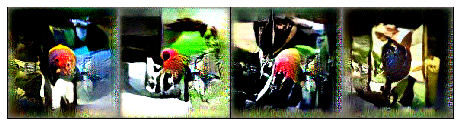

In [36]:
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
for ci in [0, 1, 2]:
    H,W,_ = Hmaps.shape
    sp_mask = np.pad(np.ones([2,2,1]), ((H//2-1+bdr,H-H//2-1+bdr),(W//2-1+bdr, W-W//2-1+bdr),(0,0)),mode="constant",
                     constant_values=-0.005)
    # show_img(sp_mask[:,:,0])
    fact_Chtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, ci:ci+1], sp_mask))
    scorer.register_weights({layer: fact_Chtsr})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.05, MAXSTEP=100, imshow=True, verbose=False)
scorer.clear_hook()

Next let's test, if we have a model neuron with these 3 components can we recreate the original prototype through
evolution / Gradient optimization?

step 124, score 0.38 0.57 0.30 0.55 0.57: 100%|██████████| 125/125 [00:11<00:00, 10.51it/s]   


Feature Correlator Destructed, Hooks deleted.
Final scores 0.57 0.57 0.55 0.38 0.30


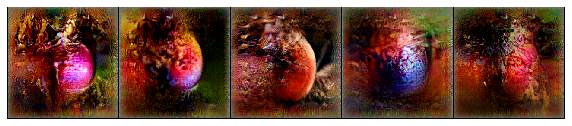

In [40]:
padded_mask = np.pad(Hmaps[:,:,:], ((bdr,bdr),(bdr,bdr),(0,0)), mode="constant")
DR_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, :], padded_mask))
DR_Wtsr.shape
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
scorer.register_weights({layer: 10*DR_Wtsr}) #
finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.02,
      MAXSTEP=125, imshow=True, verbose=False, langevin_eps=0.02, Bsize=5)
scorer.clear_hook()

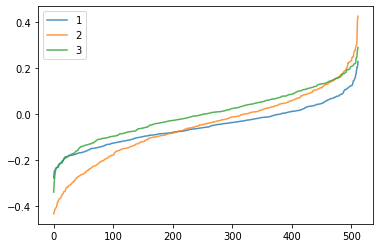

In [33]:
plt.plot(np.sort(ccfactor,axis=0), alpha=0.8)
plt.legend([1,2,3])
plt.ylabel("")
plt.show()

In [105]:
# Use pseudo inverse to compute the regression factors along the channel dimension.
np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]

0.7044371898945597

Test Scorer prediction is good based on the factorized weights

In [41]:
from data_loader import load_score_mat, loadmat, mat_path
from CorrFeatTsr_lib import visualize_cctsr, visualize_cctsr_embed, Corr_Feat_Machine, Corr_Feat_pipeline, loadimg_preprocess, loadimg_embed_preprocess
from tqdm import tqdm

In [43]:
MStats = loadmat(join(mat_path, Animal + "_Manif_stats.mat"), struct_as_record=False, squeeze_me=True)['Stats']
EStats = loadmat(join(mat_path, Animal + "_Evol_stats.mat"), struct_as_record=False, squeeze_me=True, chars_as_strings=True)['EStats']
score_vect, imgfullpath_vect = load_score_mat(EStats, MStats, Expi, "Manif_avg", wdws=[(50, 200)], stimdrive="S")

In [46]:
def score_images(featNet, scorer, layername, imgfps, imgloader=loadimg_preprocess, batchsize=40,):
    imgN = len(imgfps)
    csr = 0
    pbar = tqdm(total=imgN)
    score_all = []
    while csr < imgN:
        cend = min(csr + batchsize, imgN)
        input_tsr = imgloader(imgfps[csr:cend], borderblur=True)  # imgpix=120, fullimgsz=224
        with torch.no_grad():
            part_tsr = featNet(input_tsr.cuda()).cpu()
            score = scorer.corrfeat_score(layername)
        score_all.append(score.detach().clone().cpu())
        pbar.update(cend - csr)
        csr = cend
    pbar.close()
    score_all = torch.cat(tuple(score_all), dim=0)
    return score_all

padded_mask = np.pad(Hmaps[:,:,:], ((bdr,bdr),(bdr,bdr),(0,0)), mode="constant")
DR_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, :], padded_mask))

scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
scorer.register_weights({layer: DR_Wtsr})
pred_score = score_images(VGG.features, scorer, layer, imgfullpath_vect, imgloader=loadimg_preprocess, batchsize=40,)
scorer.clear_hook()
cc = np.corrcoef(score_vect, pred_score.numpy())[0, 1]
print("Predict ~ score Corr %.3f"%cc)

D:\Github\Visual_Neuron_Modelling\CorrFeatTsr_visualize.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight_tsr[layer] = torch.tensor(weight).float().cuda()
100%|██████████| 121/121 [00:01<00:00, 76.86it/s]


Predict ~ score Corr 0.875


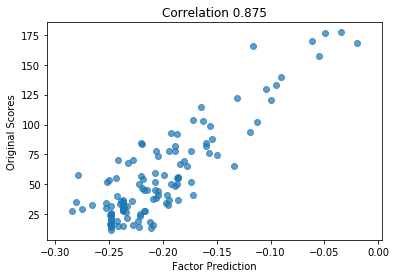

In [48]:
plt.scatter(pred_score.numpy(), score_vect, alpha=0.7)
plt.xlabel("Factor Prediction")
plt.ylabel("Original Scores")
plt.title("Correlation %.3f"%(np.corrcoef(score_vect, pred_score.numpy())[0, 1]))
plt.show()

NameError: name 'ccfactor' is not defined

0.8496500967486587

In [304]:
del scorer
# reshape to channel by space

# NMF factorize

# Reshape spatial factors

# Normalize spatial factors

# visualize plot 3 channel plot

In [ ]:
mode = "abs"#"thresh"#pos_rect
thr = (-4,4)
layer = "conv4_3"
bdr = 2
Ttsr = Ttsr_dict[layer]
cctsr = cctsr_dict[layer]
Ttsr_pp = rectify_tsr(Ttsr, mode="thresh", thr=thr)
C, H, W = Ttsr_pp.shape
if bdr == 0:
    Tmat = Ttsr_pp.reshape(C, H*W)
    ccmat = cctsr.reshape(C, H*W)
else:
    Tmat = Ttsr_pp[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
    ccmat = cctsr[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
#%
nmfsolver = NMF(n_components=3, init="nndsvda", solver="cd")#mu
Hmat = nmfsolver.fit_transform(Tmat.T)
Hmaps = Hmat.reshape([H-2*bdr, W-2*bdr, 3])
exp_var = 1-npnorm(Tmat.T-Hmat@nmfsolver.components_)/npnorm(Tmat)
print("NMF explained variance %.3f"%exp_var)
plt.imshow(Hmaps / Hmaps.max())
plt.title("channel merged")
plt.show()
[figh, axs] = plt.subplots(1,3,figsize=[9, 2.5])
for ci in range(Hmaps.shape[2]):
    plt.sca(axs[ci])
    plt.imshow(Hmaps[:,:,ci] / Hmaps.max())
    plt.axis("off")
    plt.colorbar()
plt.suptitle("Separate Factors")
plt.show()

ccfactor = (ccmat @ np.linalg.pinv(Hmat).T )
# ccfactor = (ccmat @ Hmat )
np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]

featvecs = nmfsolver.components_
fact_norms = []
for i in range(Hmaps.shape[2]):
    rank1_mat = Hmat[:, i:i+1]@featvecs[i:i+1, :]
    matnorm = npnorm(rank1_mat, ord="fro")
    fact_norms.append(matnorm)
    print("Factor%d norm %.2f"%(i, matnorm))